In [1]:
import gaussian_random_fields as gr
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image
import torch
from ddpm import *

Importing MNIST images for testing

In [2]:
digit = 5
dataset = torchvision.datasets.MNIST(root='./data',train=True, download=True)
idx = dataset.targets==digit
data = dataset.data[idx]

transform_norm = torchvision.transforms.Compose([
    torchvision.transforms.Normalize((32.8311,), (77.4151,))
])
data_trans = transform_norm(data.type(torch.float))
data_trans = data_trans[:,None,:,:]


Selecting an image to test noise addition to it using direct and indirect methods

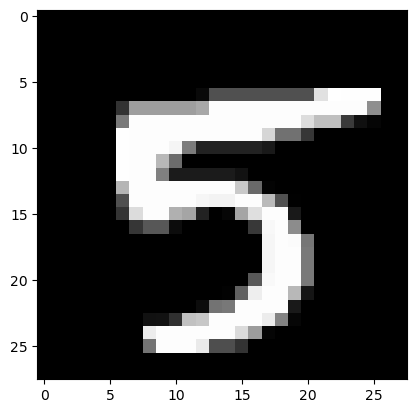

In [8]:
image_id = 123
x0 = data_trans[image_id]
plt.imshow(x0[0], cmap='gray')
max_pixel = torch.max(x0)
min_pixel = torch.min(x0)

Adding noise to the image above for 'skip_steps' steps. The parameter in the gaussian random field is 'tau'. 'x_t_direct' are samples of image with GRF noises added directly using a formula used in the paper https://arxiv.org/pdf/2211.02590.pdf (equation 11). 'x_t_indirect' are the samples of the image after adding noise step by step. 'samples' stores the number of noisy images sampled by adding noise for 'skip_step' steps. 

In [10]:
skip_steps = 750
noise_steps = 1000
samples = 10000
beta_start=1e-4
beta_end=0.02
tau = 0.2
device = "cpu"

#Making sample copies of the same image to add noise to these copies seperately and plot marginal distribution
x0 = x0.repeat(samples,1,1,1)

#Initializing the noise schedule and total noise steps in the diffusion model
diffusion = Diffusion(noise_steps=noise_steps, beta_start=beta_start, beta_end=beta_end, img_size=28
                      , device=device, channels=1, tau=tau)

#Adding the GRF noise directly using formula in one step
t = torch.zeros(samples) + skip_steps
x_t_direct, _ = diffusion.noise_images(x0, t.type(torch.long))

#Adding the GRF noise indirectly step by step
x_t_indirect = x0
for i in range(1, skip_steps+1):
    alpha_t = torch.zeros(samples) + diffusion.alpha[i]
    beta_t = torch.zeros(samples) + diffusion.beta[i]
    Ɛ = gr.gaussian_random_field(alpha=tau, size=28, samples=samples, channels=1).to(device)
    x_t_indirect = torch.sqrt(alpha_t)[:, None, None, None] * x_t_indirect + torch.sqrt(beta_t)[:, None, None, None] * Ɛ

/home/rishabh/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642881969/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Below I have plotted the marginal distribution of 4 selected pixels in the sampled noisy images, with mean of the pixels indicated too for both direct as well as step-by-step noise addition cases.  

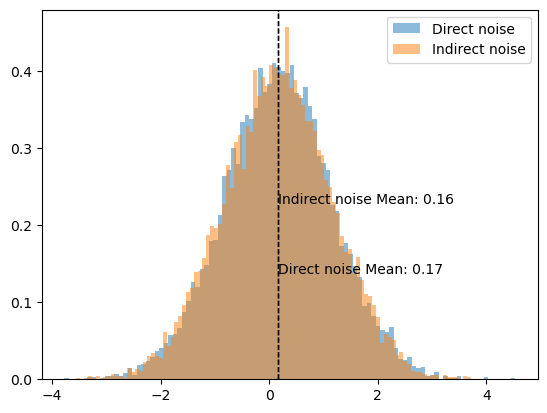

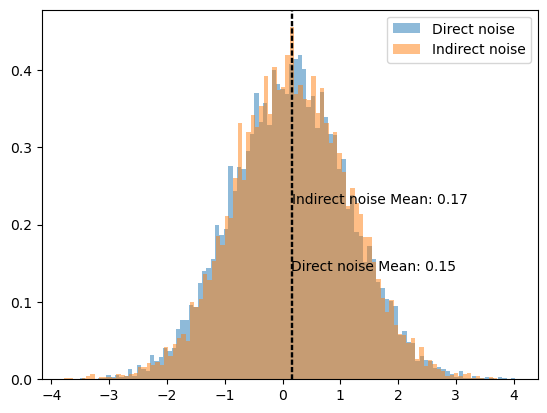

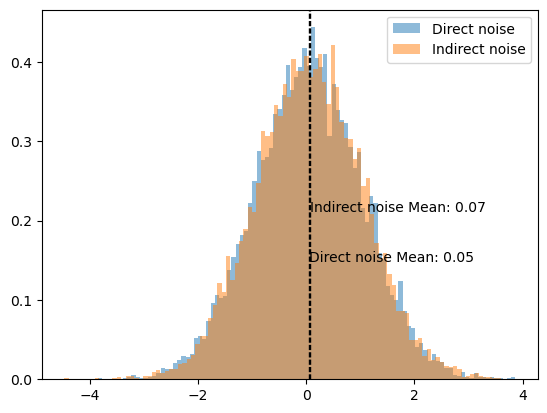

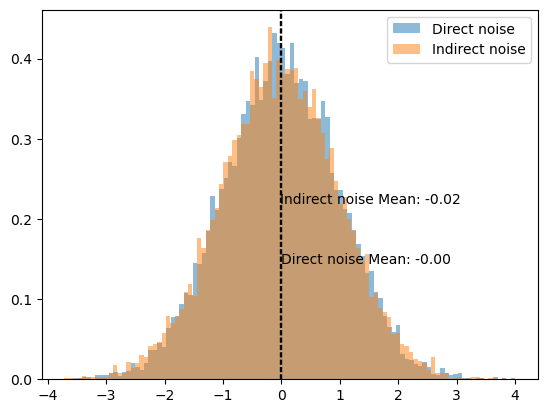

<Figure size 640x480 with 0 Axes>

In [11]:
pixel = [[15, 8], [10, 10], [20, 20], [25, 20]]

x = np.linspace(-5,5,100)
y = 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)

for i in range(len(pixel)):
    
    a = x_t_direct[:, 0, pixel[i][0], pixel[i][1]]
    b = x_t_indirect[:, 0, pixel[i][0], pixel[i][1]]
    a_mean = torch.mean(a)
    b_mean = torch.mean(b)
    
    y, _, _ = plt.hist(a, bins=100, density=True, alpha=0.5, label='Direct noise')
    plt.axvline(a_mean, color='k', linestyle='dashed', linewidth=1)
    plt.text(a_mean, np.max(y)/3, 'Direct noise Mean: {:.2f}'.format(a_mean))
    plt.legend()
    
    y, _, _ = plt.hist(b, bins=100, density=True, alpha=0.5, label='Indirect noise')
    plt.axvline(b_mean, color='k', linestyle='dashed', linewidth=1)
    plt.text(b_mean, np.max(y)/2, 'Indirect noise Mean: {:.2f}'.format(b_mean))
    plt.legend()
    plt.figure()

plt.show()

The average of the samples of noisy images after adding the noise for 'skip_steps' steps. 

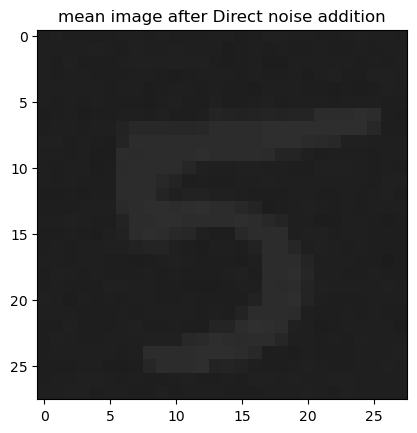

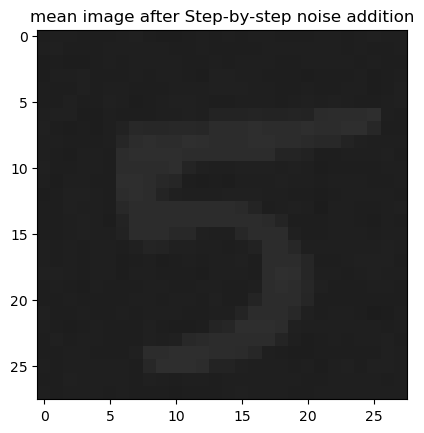

In [14]:
x_direct_avg = 0 
x_indirect_avg = 0

for i in range(samples):
    x_direct_avg += x_t_direct[i,0]
    x_indirect_avg += x_t_indirect[i,0] 
plt.imshow(x_direct_avg/samples, cmap='gray', vmin=min_pixel, vmax=max_pixel)
plt.title('mean image after Direct noise addition')
plt.figure()
plt.imshow(x_indirect_avg/samples, cmap='gray', vmin=min_pixel, vmax=max_pixel)
plt.title('mean image after Step-by-step noise addition')
plt.show()